<a href="https://colab.research.google.com/github/mohit2494/ML-CAP-6610-GAN-VAE/blob/main/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Autoencoders**
----
### Mohit Kalra
### ML CAP 6610



In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [7]:


# batch size for breaking down the training and test data
batch__size=100
shuffle_for_training=True
shuffle_for_testing=False

# download mnist digit dataset from datasets by torchivision
dataset_for_training = datasets.MNIST(
                      root='./mnist_data/', 
                      train=True, 
                      transform=transforms.ToTensor(), 
                      download=True)

dataset_for_testing = datasets.MNIST(
                      root='./mnist_data/',
                      train=False,
                      transform=transforms.ToTensor(),
                      download=False)

# Create data loader pipeline of training data
training_data_loader = torch.utils.data.DataLoader(
                                dataset=dataset_for_training,
                                batch_size=batch__size,
                                shuffle=shuffle_for_training)

# Create data loader pipeline of testing data
testing_data_loader = torch.utils.data.DataLoader(
                              dataset=dataset_for_testing,
                              batch_size=batch__size,
                              shuffle=shuffle_for_testing)

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dimension, hidden_layer1_dim, hidden_layer2_dim, latent_space_dimension):
        super(VAE, self).__init__()
        
        # encoder part
        self.input_layer = nn.Linear(input_dimension, hidden_layer1_dim)
        self.hidden_layer_2 = nn.Linear(hidden_layer1_dim, hidden_layer2_dim)
        self.latent_space_layer1 = nn.Linear(hidden_layer2_dim, latent_space_dimension)
        self.latent_space_layer2 = nn.Linear(hidden_layer2_dim, latent_space_dimension)
        # decoder part
        self.hidden_layer_4 = nn.Linear(latent_space_dimension, hidden_layer2_dim)
        self.hidden_layer_5 = nn.Linear(hidden_layer2_dim, hidden_layer1_dim)
        self.hidden_layer_6 = nn.Linear(hidden_layer1_dim, input_dimension)
        
    def encoder(self, x):
        h = F.relu(self.input_layer(x))
        h = F.relu(self.hidden_layer_2(h))
        return self.latent_space_layer1(h), self.latent_space_layer2(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.hidden_layer_4(z))
        h = F.relu(self.hidden_layer_5(h))
        return F.sigmoid(self.hidden_layer_6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(input_dimension=784, hidden_layer1_dim= 512, hidden_layer2_dim=256, latent_space_dimension=2)
if torch.cuda.is_available():
    vae.cuda()

In [9]:
vae

VAE(
  (input_layer): Linear(in_features=784, out_features=512, bias=True)
  (hidden_layer_2): Linear(in_features=512, out_features=256, bias=True)
  (latent_space_layer1): Linear(in_features=256, out_features=2, bias=True)
  (latent_space_layer2): Linear(in_features=256, out_features=2, bias=True)
  (hidden_layer_4): Linear(in_features=2, out_features=256, bias=True)
  (hidden_layer_5): Linear(in_features=256, out_features=512, bias=True)
  (hidden_layer_6): Linear(in_features=512, out_features=784, bias=True)
)

In [10]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(reconstruction_error, x, distr_mu, distr_log_var):
    binary_cross_entropy_error = F.binary_cross_entropy(reconstruction_error, x.view(-1, 784), reduction='sum')
    KL_divergence = -0.5 * torch.sum(1 + distr_log_var - distr_mu.pow(2) - distr_log_var.exp())
    return binary_cross_entropy_error + KL_divergence

In [11]:
def train_vae(epoch):
    vae.train()
    training_loss = 0
    for batch_index, (data, _) in enumerate(training_data_loader):
        
        data = data.cuda()
        optimizer.zero_grad()
        
        reconstruction_batch, distr_mu, distr_log_var = vae(data)
        loss = loss_function(reconstruction_batch, data, distr_mu, distr_log_var)
        
        loss.backward()
        training_loss += loss.item()
        optimizer.step()
        
        current_epoch = epoch+1

        if batch_index % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tObserved Loss: {:.6f}'.format(
                current_epoch, 
                batch_index * len(data), 
                len(training_data_loader.dataset),
                100. * batch_index / len(training_data_loader), 
                loss.item() / len(data)))
    
    print('====> Epoch Number: {} Average loss for epoch: {:.4f}'.format(
        current_epoch, 
        training_loss / len(training_data_loader.dataset)
    ))

In [12]:
def test_vae():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testing_data_loader:
            data = data.cuda()
            reconstruction, distr_mu, dist_log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(reconstruction, data, distr_mu, dist_log_var).item()
        
    test_loss /= len(testing_data_loader.dataset)
    print('====> Observed loss for test set: {:.4f}'.format(test_loss))

In [13]:
from PIL import Image               # to load images
from IPython.display import display # to display images
display_after_epoch = 10
def snapshot(epoch):
  with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    print("\n*************Taking progress snapshot*****************\n")
    filename = 'epoch_'+str(id)+'.jpg'
    save_image(sample.view(64, 1, 28, 28), filename)
    pil_im = Image.open(filename)
    display(pil_im)
    print("\n*******************************************************\n")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Observed Loss: 544.382344
Train Epoch: 1 [10000/60000 (17%)]	Observed Loss: 193.740664
Train Epoch: 1 [20000/60000 (33%)]	Observed Loss: 171.229375
Train Epoch: 1 [30000/60000 (50%)]	Observed Loss: 177.671328
Train Epoch: 1 [40000/60000 (67%)]	Observed Loss: 165.917559
Train Epoch: 1 [50000/60000 (83%)]	Observed Loss: 166.175938
====> Epoch Number: 1 Average loss for epoch: 179.0528
====> Observed loss for test set: 162.9555
Train Epoch: 2 [0/60000 (0%)]	Observed Loss: 161.559121
Train Epoch: 2 [10000/60000 (17%)]	Observed Loss: 162.199033
Train Epoch: 2 [20000/60000 (33%)]	Observed Loss: 157.993730
Train Epoch: 2 [30000/60000 (50%)]	Observed Loss: 163.186211
Train Epoch: 2 [40000/60000 (67%)]	Observed Loss: 158.742656
Train Epoch: 2 [50000/60000 (83%)]	Observed Loss: 153.429287
====> Epoch Number: 2 Average loss for epoch: 158.0510
====> Observed loss for test set: 154.7267
Train Epoch: 3 [0/60000 (0%)]	Observed Loss: 152.236055
Train Epoch: 3 [10000/6000

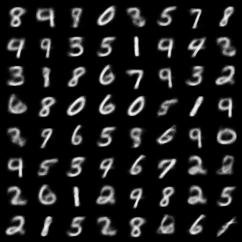


*******************************************************

Train Epoch: 11 [0/60000 (0%)]	Observed Loss: 140.212246
Train Epoch: 11 [10000/60000 (17%)]	Observed Loss: 145.044512
Train Epoch: 11 [20000/60000 (33%)]	Observed Loss: 147.556299
Train Epoch: 11 [30000/60000 (50%)]	Observed Loss: 147.368184
Train Epoch: 11 [40000/60000 (67%)]	Observed Loss: 150.674941
Train Epoch: 11 [50000/60000 (83%)]	Observed Loss: 146.619795
====> Epoch Number: 11 Average loss for epoch: 141.7144
====> Observed loss for test set: 142.6176
Train Epoch: 12 [0/60000 (0%)]	Observed Loss: 131.248477
Train Epoch: 12 [10000/60000 (17%)]	Observed Loss: 139.798311
Train Epoch: 12 [20000/60000 (33%)]	Observed Loss: 138.785840
Train Epoch: 12 [30000/60000 (50%)]	Observed Loss: 142.214727
Train Epoch: 12 [40000/60000 (67%)]	Observed Loss: 134.352734
Train Epoch: 12 [50000/60000 (83%)]	Observed Loss: 149.012754
====> Epoch Number: 12 Average loss for epoch: 141.1427
====> Observed loss for test set: 142.2823
Train Epoc

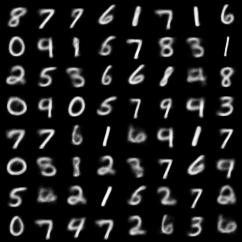


*******************************************************

Train Epoch: 21 [0/60000 (0%)]	Observed Loss: 134.894346
Train Epoch: 21 [10000/60000 (17%)]	Observed Loss: 144.831826
Train Epoch: 21 [20000/60000 (33%)]	Observed Loss: 130.757734
Train Epoch: 21 [30000/60000 (50%)]	Observed Loss: 137.916191
Train Epoch: 21 [40000/60000 (67%)]	Observed Loss: 132.307510
Train Epoch: 21 [50000/60000 (83%)]	Observed Loss: 139.946240
====> Epoch Number: 21 Average loss for epoch: 138.2595
====> Observed loss for test set: 140.1518
Train Epoch: 22 [0/60000 (0%)]	Observed Loss: 128.351670
Train Epoch: 22 [10000/60000 (17%)]	Observed Loss: 138.875840
Train Epoch: 22 [20000/60000 (33%)]	Observed Loss: 137.718740
Train Epoch: 22 [30000/60000 (50%)]	Observed Loss: 143.562969
Train Epoch: 22 [40000/60000 (67%)]	Observed Loss: 138.790254
Train Epoch: 22 [50000/60000 (83%)]	Observed Loss: 133.935146
====> Epoch Number: 22 Average loss for epoch: 138.2857
====> Observed loss for test set: 139.8838
Train Epoc

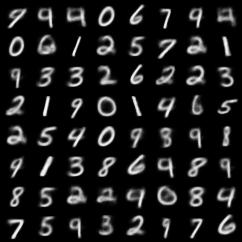


*******************************************************

Train Epoch: 31 [0/60000 (0%)]	Observed Loss: 124.343936
Train Epoch: 31 [10000/60000 (17%)]	Observed Loss: 137.334521
Train Epoch: 31 [20000/60000 (33%)]	Observed Loss: 140.716777
Train Epoch: 31 [30000/60000 (50%)]	Observed Loss: 134.868389
Train Epoch: 31 [40000/60000 (67%)]	Observed Loss: 136.277559
Train Epoch: 31 [50000/60000 (83%)]	Observed Loss: 139.815908
====> Epoch Number: 31 Average loss for epoch: 137.2081
====> Observed loss for test set: 139.1909
Train Epoch: 32 [0/60000 (0%)]	Observed Loss: 131.138945
Train Epoch: 32 [10000/60000 (17%)]	Observed Loss: 132.411963
Train Epoch: 32 [20000/60000 (33%)]	Observed Loss: 138.812930
Train Epoch: 32 [30000/60000 (50%)]	Observed Loss: 135.085537
Train Epoch: 32 [40000/60000 (67%)]	Observed Loss: 137.803652
Train Epoch: 32 [50000/60000 (83%)]	Observed Loss: 140.079219
====> Epoch Number: 32 Average loss for epoch: 136.7851
====> Observed loss for test set: 139.0864
Train Epoc

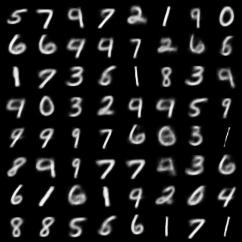


*******************************************************

Train Epoch: 41 [0/60000 (0%)]	Observed Loss: 143.391533
Train Epoch: 41 [10000/60000 (17%)]	Observed Loss: 138.516670
Train Epoch: 41 [20000/60000 (33%)]	Observed Loss: 128.750928
Train Epoch: 41 [30000/60000 (50%)]	Observed Loss: 127.874766
Train Epoch: 41 [40000/60000 (67%)]	Observed Loss: 132.449258
Train Epoch: 41 [50000/60000 (83%)]	Observed Loss: 135.856562
====> Epoch Number: 41 Average loss for epoch: 135.9310
====> Observed loss for test set: 138.4285
Train Epoch: 42 [0/60000 (0%)]	Observed Loss: 134.834248
Train Epoch: 42 [10000/60000 (17%)]	Observed Loss: 132.208262
Train Epoch: 42 [20000/60000 (33%)]	Observed Loss: 141.023311
Train Epoch: 42 [30000/60000 (50%)]	Observed Loss: 132.764541
Train Epoch: 42 [40000/60000 (67%)]	Observed Loss: 132.803789
Train Epoch: 42 [50000/60000 (83%)]	Observed Loss: 141.022969
====> Epoch Number: 42 Average loss for epoch: 135.6344
====> Observed loss for test set: 138.5249
Train Epoc

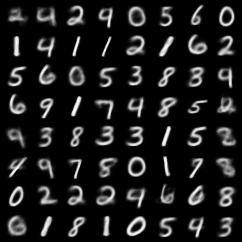


*******************************************************

Train Epoch: 51 [0/60000 (0%)]	Observed Loss: 133.122734
Train Epoch: 51 [10000/60000 (17%)]	Observed Loss: 127.158877
Train Epoch: 51 [20000/60000 (33%)]	Observed Loss: 136.255762
Train Epoch: 51 [30000/60000 (50%)]	Observed Loss: 130.916328
Train Epoch: 51 [40000/60000 (67%)]	Observed Loss: 135.681992
Train Epoch: 51 [50000/60000 (83%)]	Observed Loss: 130.600459
====> Epoch Number: 51 Average loss for epoch: 135.1398
====> Observed loss for test set: 138.5571
Train Epoch: 52 [0/60000 (0%)]	Observed Loss: 136.174453
Train Epoch: 52 [10000/60000 (17%)]	Observed Loss: 136.491270
Train Epoch: 52 [20000/60000 (33%)]	Observed Loss: 125.259463
Train Epoch: 52 [30000/60000 (50%)]	Observed Loss: 140.095918
Train Epoch: 52 [40000/60000 (67%)]	Observed Loss: 136.129463
Train Epoch: 52 [50000/60000 (83%)]	Observed Loss: 142.996426
====> Epoch Number: 52 Average loss for epoch: 134.9967
====> Observed loss for test set: 138.0899
Train Epoc

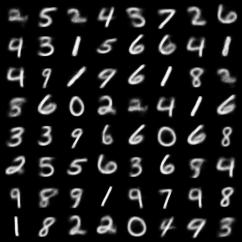


*******************************************************

Train Epoch: 61 [0/60000 (0%)]	Observed Loss: 134.784521
Train Epoch: 61 [10000/60000 (17%)]	Observed Loss: 132.623174
Train Epoch: 61 [20000/60000 (33%)]	Observed Loss: 131.272949
Train Epoch: 61 [30000/60000 (50%)]	Observed Loss: 131.293877
Train Epoch: 61 [40000/60000 (67%)]	Observed Loss: 134.163828
Train Epoch: 61 [50000/60000 (83%)]	Observed Loss: 139.772207
====> Epoch Number: 61 Average loss for epoch: 134.2997
====> Observed loss for test set: 137.7177
Train Epoch: 62 [0/60000 (0%)]	Observed Loss: 132.714922
Train Epoch: 62 [10000/60000 (17%)]	Observed Loss: 133.829863
Train Epoch: 62 [20000/60000 (33%)]	Observed Loss: 133.656309
Train Epoch: 62 [30000/60000 (50%)]	Observed Loss: 139.488867
Train Epoch: 62 [40000/60000 (67%)]	Observed Loss: 137.985693
Train Epoch: 62 [50000/60000 (83%)]	Observed Loss: 132.168916
====> Epoch Number: 62 Average loss for epoch: 134.1673
====> Observed loss for test set: 138.0603
Train Epoc

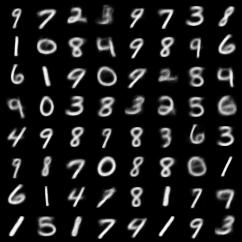


*******************************************************

Train Epoch: 71 [0/60000 (0%)]	Observed Loss: 128.043564
Train Epoch: 71 [10000/60000 (17%)]	Observed Loss: 128.805830
Train Epoch: 71 [20000/60000 (33%)]	Observed Loss: 134.829648
Train Epoch: 71 [30000/60000 (50%)]	Observed Loss: 132.413545
Train Epoch: 71 [40000/60000 (67%)]	Observed Loss: 133.779951
Train Epoch: 71 [50000/60000 (83%)]	Observed Loss: 136.853340
====> Epoch Number: 71 Average loss for epoch: 133.5491
====> Observed loss for test set: 137.5684
Train Epoch: 72 [0/60000 (0%)]	Observed Loss: 132.774268
Train Epoch: 72 [10000/60000 (17%)]	Observed Loss: 139.630195
Train Epoch: 72 [20000/60000 (33%)]	Observed Loss: 133.556748
Train Epoch: 72 [30000/60000 (50%)]	Observed Loss: 131.837041
Train Epoch: 72 [40000/60000 (67%)]	Observed Loss: 138.432314
Train Epoch: 72 [50000/60000 (83%)]	Observed Loss: 131.011416
====> Epoch Number: 72 Average loss for epoch: 133.5946
====> Observed loss for test set: 137.2854
Train Epoc

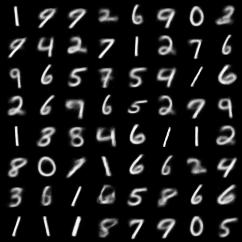


*******************************************************

Train Epoch: 81 [0/60000 (0%)]	Observed Loss: 138.605723
Train Epoch: 81 [10000/60000 (17%)]	Observed Loss: 125.968955
Train Epoch: 81 [20000/60000 (33%)]	Observed Loss: 140.389238
Train Epoch: 81 [30000/60000 (50%)]	Observed Loss: 126.684902
Train Epoch: 81 [40000/60000 (67%)]	Observed Loss: 127.349150
Train Epoch: 81 [50000/60000 (83%)]	Observed Loss: 131.440059
====> Epoch Number: 81 Average loss for epoch: 133.0453
====> Observed loss for test set: 137.7082
Train Epoch: 82 [0/60000 (0%)]	Observed Loss: 129.711396
Train Epoch: 82 [10000/60000 (17%)]	Observed Loss: 130.210146
Train Epoch: 82 [20000/60000 (33%)]	Observed Loss: 136.204854
Train Epoch: 82 [30000/60000 (50%)]	Observed Loss: 140.671973
Train Epoch: 82 [40000/60000 (67%)]	Observed Loss: 134.382051
Train Epoch: 82 [50000/60000 (83%)]	Observed Loss: 134.935459
====> Epoch Number: 82 Average loss for epoch: 132.9134
====> Observed loss for test set: 137.4580
Train Epoc

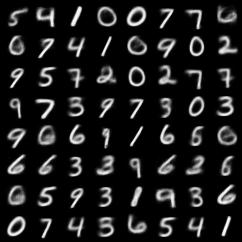


*******************************************************

Train Epoch: 91 [0/60000 (0%)]	Observed Loss: 128.918350
Train Epoch: 91 [10000/60000 (17%)]	Observed Loss: 133.810029
Train Epoch: 91 [20000/60000 (33%)]	Observed Loss: 134.783936
Train Epoch: 91 [30000/60000 (50%)]	Observed Loss: 132.607686
Train Epoch: 91 [40000/60000 (67%)]	Observed Loss: 125.962754
Train Epoch: 91 [50000/60000 (83%)]	Observed Loss: 129.177432
====> Epoch Number: 91 Average loss for epoch: 132.6405
====> Observed loss for test set: 137.8727
Train Epoch: 92 [0/60000 (0%)]	Observed Loss: 131.997637
Train Epoch: 92 [10000/60000 (17%)]	Observed Loss: 142.271670
Train Epoch: 92 [20000/60000 (33%)]	Observed Loss: 135.221436
Train Epoch: 92 [30000/60000 (50%)]	Observed Loss: 132.215313
Train Epoch: 92 [40000/60000 (67%)]	Observed Loss: 134.650156
Train Epoch: 92 [50000/60000 (83%)]	Observed Loss: 123.528047
====> Epoch Number: 92 Average loss for epoch: 132.6441
====> Observed loss for test set: 137.4834
Train Epoc

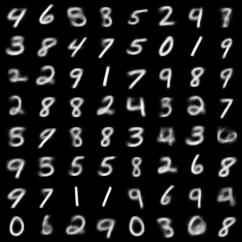


*******************************************************

Train Epoch: 101 [0/60000 (0%)]	Observed Loss: 124.416641
Train Epoch: 101 [10000/60000 (17%)]	Observed Loss: 134.005410
Train Epoch: 101 [20000/60000 (33%)]	Observed Loss: 128.481738
Train Epoch: 101 [30000/60000 (50%)]	Observed Loss: 125.665322
Train Epoch: 101 [40000/60000 (67%)]	Observed Loss: 129.492383
Train Epoch: 101 [50000/60000 (83%)]	Observed Loss: 132.416211
====> Epoch Number: 101 Average loss for epoch: 132.2584
====> Observed loss for test set: 137.6700
Train Epoch: 102 [0/60000 (0%)]	Observed Loss: 130.618252
Train Epoch: 102 [10000/60000 (17%)]	Observed Loss: 126.358525
Train Epoch: 102 [20000/60000 (33%)]	Observed Loss: 136.423438
Train Epoch: 102 [30000/60000 (50%)]	Observed Loss: 130.332402
Train Epoch: 102 [40000/60000 (67%)]	Observed Loss: 128.127080
Train Epoch: 102 [50000/60000 (83%)]	Observed Loss: 130.049424
====> Epoch Number: 102 Average loss for epoch: 132.1735
====> Observed loss for test set: 138.0

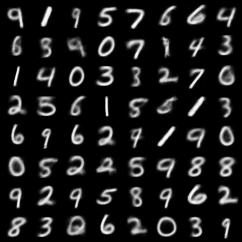


*******************************************************

Train Epoch: 111 [0/60000 (0%)]	Observed Loss: 132.231680
Train Epoch: 111 [10000/60000 (17%)]	Observed Loss: 123.138867
Train Epoch: 111 [20000/60000 (33%)]	Observed Loss: 127.986738
Train Epoch: 111 [30000/60000 (50%)]	Observed Loss: 128.099912
Train Epoch: 111 [40000/60000 (67%)]	Observed Loss: 134.071406
Train Epoch: 111 [50000/60000 (83%)]	Observed Loss: 130.679941
====> Epoch Number: 111 Average loss for epoch: 132.1754
====> Observed loss for test set: 138.4080
Train Epoch: 112 [0/60000 (0%)]	Observed Loss: 132.490371
Train Epoch: 112 [10000/60000 (17%)]	Observed Loss: 131.211523
Train Epoch: 112 [20000/60000 (33%)]	Observed Loss: 128.436006
Train Epoch: 112 [30000/60000 (50%)]	Observed Loss: 131.900078
Train Epoch: 112 [40000/60000 (67%)]	Observed Loss: 122.862207
Train Epoch: 112 [50000/60000 (83%)]	Observed Loss: 127.654199
====> Epoch Number: 112 Average loss for epoch: 131.9893
====> Observed loss for test set: 137.7

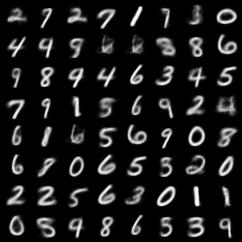


*******************************************************

Train Epoch: 121 [0/60000 (0%)]	Observed Loss: 136.814941
Train Epoch: 121 [10000/60000 (17%)]	Observed Loss: 128.693057
Train Epoch: 121 [20000/60000 (33%)]	Observed Loss: 128.081699
Train Epoch: 121 [30000/60000 (50%)]	Observed Loss: 138.923281
Train Epoch: 121 [40000/60000 (67%)]	Observed Loss: 127.382773
Train Epoch: 121 [50000/60000 (83%)]	Observed Loss: 137.051875
====> Epoch Number: 121 Average loss for epoch: 131.5339
====> Observed loss for test set: 137.4982
Train Epoch: 122 [0/60000 (0%)]	Observed Loss: 136.833984
Train Epoch: 122 [10000/60000 (17%)]	Observed Loss: 131.559346
Train Epoch: 122 [20000/60000 (33%)]	Observed Loss: 134.095908
Train Epoch: 122 [30000/60000 (50%)]	Observed Loss: 145.774121
Train Epoch: 122 [40000/60000 (67%)]	Observed Loss: 130.387100
Train Epoch: 122 [50000/60000 (83%)]	Observed Loss: 143.135498
====> Epoch Number: 122 Average loss for epoch: 132.1847
====> Observed loss for test set: 137.8

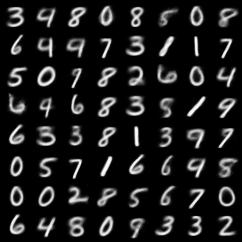


*******************************************************

Train Epoch: 131 [0/60000 (0%)]	Observed Loss: 128.097715
Train Epoch: 131 [10000/60000 (17%)]	Observed Loss: 130.966328
Train Epoch: 131 [20000/60000 (33%)]	Observed Loss: 125.577402
Train Epoch: 131 [30000/60000 (50%)]	Observed Loss: 137.305703
Train Epoch: 131 [40000/60000 (67%)]	Observed Loss: 135.995840
Train Epoch: 131 [50000/60000 (83%)]	Observed Loss: 139.442256
====> Epoch Number: 131 Average loss for epoch: 131.2475
====> Observed loss for test set: 138.1345
Train Epoch: 132 [0/60000 (0%)]	Observed Loss: 132.428740
Train Epoch: 132 [10000/60000 (17%)]	Observed Loss: 130.000186
Train Epoch: 132 [20000/60000 (33%)]	Observed Loss: 136.874883
Train Epoch: 132 [30000/60000 (50%)]	Observed Loss: 130.743193
Train Epoch: 132 [40000/60000 (67%)]	Observed Loss: 132.401660
Train Epoch: 132 [50000/60000 (83%)]	Observed Loss: 125.325723
====> Epoch Number: 132 Average loss for epoch: 131.2002
====> Observed loss for test set: 137.4

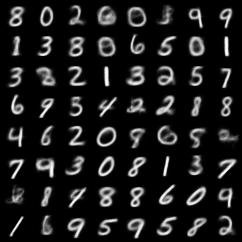


*******************************************************

Train Epoch: 141 [0/60000 (0%)]	Observed Loss: 135.937119
Train Epoch: 141 [10000/60000 (17%)]	Observed Loss: 131.176455
Train Epoch: 141 [20000/60000 (33%)]	Observed Loss: 130.050723
Train Epoch: 141 [30000/60000 (50%)]	Observed Loss: 134.151885
Train Epoch: 141 [40000/60000 (67%)]	Observed Loss: 131.155127
Train Epoch: 141 [50000/60000 (83%)]	Observed Loss: 133.192617
====> Epoch Number: 141 Average loss for epoch: 130.9600
====> Observed loss for test set: 137.5799
Train Epoch: 142 [0/60000 (0%)]	Observed Loss: 124.932344
Train Epoch: 142 [10000/60000 (17%)]	Observed Loss: 129.948457
Train Epoch: 142 [20000/60000 (33%)]	Observed Loss: 132.045283
Train Epoch: 142 [30000/60000 (50%)]	Observed Loss: 129.960430
Train Epoch: 142 [40000/60000 (67%)]	Observed Loss: 129.950078
Train Epoch: 142 [50000/60000 (83%)]	Observed Loss: 132.292158
====> Epoch Number: 142 Average loss for epoch: 130.8399
====> Observed loss for test set: 137.4

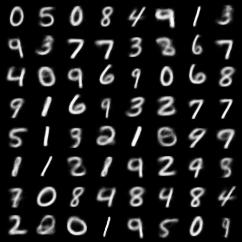


*******************************************************

Train Epoch: 151 [0/60000 (0%)]	Observed Loss: 130.311055
Train Epoch: 151 [10000/60000 (17%)]	Observed Loss: 132.756973
Train Epoch: 151 [20000/60000 (33%)]	Observed Loss: 127.489873
Train Epoch: 151 [30000/60000 (50%)]	Observed Loss: 128.818994
Train Epoch: 151 [40000/60000 (67%)]	Observed Loss: 123.582627
Train Epoch: 151 [50000/60000 (83%)]	Observed Loss: 125.190596
====> Epoch Number: 151 Average loss for epoch: 130.7297
====> Observed loss for test set: 138.1788
Train Epoch: 152 [0/60000 (0%)]	Observed Loss: 129.836025
Train Epoch: 152 [10000/60000 (17%)]	Observed Loss: 135.237930
Train Epoch: 152 [20000/60000 (33%)]	Observed Loss: 131.959258
Train Epoch: 152 [30000/60000 (50%)]	Observed Loss: 124.912031
Train Epoch: 152 [40000/60000 (67%)]	Observed Loss: 135.103096
Train Epoch: 152 [50000/60000 (83%)]	Observed Loss: 126.278096
====> Epoch Number: 152 Average loss for epoch: 130.9060
====> Observed loss for test set: 137.4

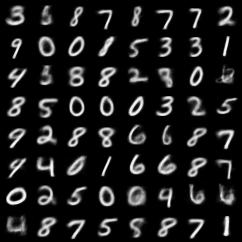


*******************************************************

Train Epoch: 161 [0/60000 (0%)]	Observed Loss: 137.807832
Train Epoch: 161 [10000/60000 (17%)]	Observed Loss: 130.513965
Train Epoch: 161 [20000/60000 (33%)]	Observed Loss: 128.471494
Train Epoch: 161 [30000/60000 (50%)]	Observed Loss: 122.282080
Train Epoch: 161 [40000/60000 (67%)]	Observed Loss: 129.747178
Train Epoch: 161 [50000/60000 (83%)]	Observed Loss: 126.050332
====> Epoch Number: 161 Average loss for epoch: 130.4863
====> Observed loss for test set: 138.3045
Train Epoch: 162 [0/60000 (0%)]	Observed Loss: 132.253311
Train Epoch: 162 [10000/60000 (17%)]	Observed Loss: 131.067158
Train Epoch: 162 [20000/60000 (33%)]	Observed Loss: 128.528779
Train Epoch: 162 [30000/60000 (50%)]	Observed Loss: 135.109961
Train Epoch: 162 [40000/60000 (67%)]	Observed Loss: 127.170244
Train Epoch: 162 [50000/60000 (83%)]	Observed Loss: 129.876221
====> Epoch Number: 162 Average loss for epoch: 130.8865
====> Observed loss for test set: 138.2

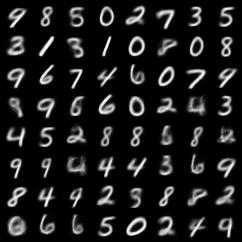


*******************************************************

Train Epoch: 171 [0/60000 (0%)]	Observed Loss: 132.927559
Train Epoch: 171 [10000/60000 (17%)]	Observed Loss: 129.764316
Train Epoch: 171 [20000/60000 (33%)]	Observed Loss: 136.875781
Train Epoch: 171 [30000/60000 (50%)]	Observed Loss: 126.066621
Train Epoch: 171 [40000/60000 (67%)]	Observed Loss: 133.291113
Train Epoch: 171 [50000/60000 (83%)]	Observed Loss: 135.173857
====> Epoch Number: 171 Average loss for epoch: 130.2798
====> Observed loss for test set: 138.3682
Train Epoch: 172 [0/60000 (0%)]	Observed Loss: 122.355791
Train Epoch: 172 [10000/60000 (17%)]	Observed Loss: 132.816934
Train Epoch: 172 [20000/60000 (33%)]	Observed Loss: 134.236719
Train Epoch: 172 [30000/60000 (50%)]	Observed Loss: 134.344883
Train Epoch: 172 [40000/60000 (67%)]	Observed Loss: 128.376104
Train Epoch: 172 [50000/60000 (83%)]	Observed Loss: 125.462070
====> Epoch Number: 172 Average loss for epoch: 130.2212
====> Observed loss for test set: 137.9

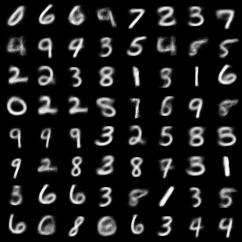


*******************************************************

Train Epoch: 181 [0/60000 (0%)]	Observed Loss: 129.997773
Train Epoch: 181 [10000/60000 (17%)]	Observed Loss: 134.526543
Train Epoch: 181 [20000/60000 (33%)]	Observed Loss: 124.641465
Train Epoch: 181 [30000/60000 (50%)]	Observed Loss: 136.160791
Train Epoch: 181 [40000/60000 (67%)]	Observed Loss: 128.298535
Train Epoch: 181 [50000/60000 (83%)]	Observed Loss: 142.866943
====> Epoch Number: 181 Average loss for epoch: 130.1849
====> Observed loss for test set: 138.0434
Train Epoch: 182 [0/60000 (0%)]	Observed Loss: 126.222656
Train Epoch: 182 [10000/60000 (17%)]	Observed Loss: 130.211719
Train Epoch: 182 [20000/60000 (33%)]	Observed Loss: 133.347734
Train Epoch: 182 [30000/60000 (50%)]	Observed Loss: 132.972373
Train Epoch: 182 [40000/60000 (67%)]	Observed Loss: 128.919219
Train Epoch: 182 [50000/60000 (83%)]	Observed Loss: 131.191846
====> Epoch Number: 182 Average loss for epoch: 130.1161
====> Observed loss for test set: 137.9

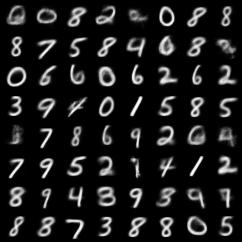


*******************************************************

Train Epoch: 191 [0/60000 (0%)]	Observed Loss: 125.907080
Train Epoch: 191 [10000/60000 (17%)]	Observed Loss: 132.735908
Train Epoch: 191 [20000/60000 (33%)]	Observed Loss: 129.424014
Train Epoch: 191 [30000/60000 (50%)]	Observed Loss: 137.284023
Train Epoch: 191 [40000/60000 (67%)]	Observed Loss: 134.238584
Train Epoch: 191 [50000/60000 (83%)]	Observed Loss: 135.366992
====> Epoch Number: 191 Average loss for epoch: 130.3361
====> Observed loss for test set: 137.8295
Train Epoch: 192 [0/60000 (0%)]	Observed Loss: 133.995537
Train Epoch: 192 [10000/60000 (17%)]	Observed Loss: 134.852930
Train Epoch: 192 [20000/60000 (33%)]	Observed Loss: 131.465176
Train Epoch: 192 [30000/60000 (50%)]	Observed Loss: 131.771836
Train Epoch: 192 [40000/60000 (67%)]	Observed Loss: 119.743184
Train Epoch: 192 [50000/60000 (83%)]	Observed Loss: 139.026484
====> Epoch Number: 192 Average loss for epoch: 130.4674
====> Observed loss for test set: 138.0

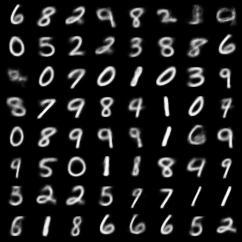


*******************************************************



In [14]:
take_snap = 10
number_of_epochs = 200
current_epoch = 0
for epoch in range(number_of_epochs):
    train_vae(epoch)
    test_vae()
    current_epoch+=1
    if current_epoch%take_snap==0:
      snapshot(current_epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
